# Financial Modeling and Estimation

v1.0 (2018 Fall) Nikunj Jain

This notebook is meant to provide a basic walkthrough through some basic techniques into modeling the stock market. We will not be presenting very advanced methods, and you should feel free to explore a lot beyond what this notebook presents. However, as an overview, these are the steps we will follow:
1. Getting data
2. Data cleaning and exploratory analysis
3. A basic linear regression model

This has been extensively adapted (for code and basic analysis) from <a href="https://pythonprogramming.net/forecasting-predicting-machine-learning-tutorial/">this</a> article.

## <font color = blue> Getting Data</font>

Before we go into making any models, we first need some data to play around with! The library we will be using is a personal favorite, called <a href="https://www.quandl.com/tools/python">Quandl</a>. This is in no means exhaustive or comprehensive, so feel free to augment these data sets as you see fit. You will need to sign up for a (free) account and include your own API key at the spot indicated.

In [301]:
%matplotlib inline

import quandl as Quandl
Quandl.ApiConfig.api_key = "VvAy1yT5shPhoYsKscWG"
import numpy as np
import pandas as pd
import math
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import datetime
style.use('ggplot')

In [302]:
class MovingAverageFilter():
    def __init__(self, cols=[7, 8, 9, 10], window_size=10):
        self.window_size = window_size
        self.cols = cols

    def filter(self, raw_data):
        raw_data = raw_data.copy()
        o, c, h, l = raw_data[:, 7], raw_data[:, 10], raw_data[:, 8], raw_data[:, 9]
        
        plt.plot(range(len(o)), o, 'r--', label='o-price-pre')
        plt.plot(range(len(c)), c, 'b--', label='c-price-pre')
        plt.plot(range(len(h)), h, 'g--', label='h-price-pre')
        plt.plot(range(len(l)), l, 'y--', label='l-price-pre')
        plt.title('Stock Prices Before Moving Average Filter')
        plt.xlabel('Day')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

        prices = raw_data[:, self.cols]
        new_prices = np.cumsum(prices, axis=0)

        new_prices[self.window_size:] = new_prices[self.window_size:] - new_prices[:-self.window_size]
        new_prices[self.window_size:] /= self.window_size

        temp_range = np.arange(self.window_size).reshape(self.window_size,1)
        prefix_divisor = np.hstack((temp_range, temp_range, temp_range, temp_range))+ 1
        length = len(new_prices[:self.window_size])
        avg = np.divide(new_prices[:self.window_size], prefix_divisor[:length])
        temp_window_size = len(avg)

        new_prices[:temp_window_size] = np.divide(new_prices[:self.window_size], prefix_divisor[:length])
        
        o, c, h, l = new_prices[:, 0], new_prices[:, 1], new_prices[:, 2], new_prices[:, 3]
        
        plt.plot(range(len(o)), o, 'r--', label='o-price-pre')
        plt.plot(range(len(c)), c, 'b--', label='c-price-pre')
        plt.plot(range(len(h)), h, 'g--', label='h-price-pre')
        plt.plot(range(len(l)), l, 'y--', label='l-price-pre')
        plt.title('Stock Prices After Moving Average Filter')
        plt.xlabel('Day')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()
        
        filtered_data = raw_data.copy()
        filtered_data[:, self.cols] = new_prices
        
        return filtered_data

In [303]:
from scipy import signal

class LowPassFilter():
    def __init__(self, cols=[7, 8, 9, 10], order=2, cutoff=0.01):
        self.order = order
        self.cutoff = cutoff
        self.cols = cols

    def filter(self, raw_data):
        raw_data = raw_data.copy()
        b, a  = signal.butter(self.order, self.cutoff)
        o, c, h, l = raw_data[:, 7], raw_data[:, 10], raw_data[:, 8], raw_data[:, 9]
        
        plt.plot(range(len(o)), o, 'r--', label='o-price-pre')
        plt.plot(range(len(c)), c, 'b--', label='c-price-pre')
        plt.plot(range(len(h)), h, 'g--', label='h-price-pre')
        plt.plot(range(len(l)), l, 'y--', label='l-price-pre')
        plt.title('Stock Prices Before Low-Pass Filter')
        plt.xlabel('Day')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

        o = signal.lfilter(b, a, o)
        c = signal.lfilter(b, a, c)
        h = signal.lfilter(b, a, h)
        l = signal.lfilter(b, a, l)

        plt.plot(range(len(o)), o, 'r', label='o-price-post')
        plt.plot(range(len(c)), c, 'b', label='c-price-post')
        plt.plot(range(len(h)), h, 'g', label='h-price-post')
        plt.plot(range(len(l)), l, 'y', label='l-price-post')
        plt.title('Stock Prices After Low-Pass Filter')
        plt.xlabel('Day')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()
        
        filtered_data = raw_data.copy()
        filtered_data[:, 7] = o
        filtered_data[:, 10] = c
        filtered_data[:, 8] = h
        filtered_data[:, 9] = l

        return filtered_data

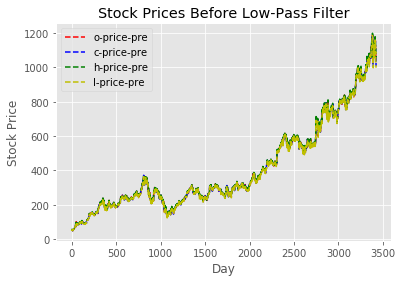

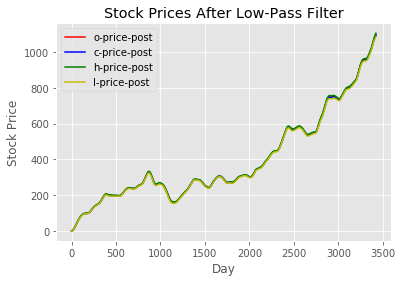

In [304]:
df = Quandl.get("WIKI/GOOGL")

# maf = MovingAverageFilter(window_size=50)
# filtered_df = pd.DataFrame(data=maf.filter(df.values), index=df.index, columns=df.columns)

lpf = LowPassFilter(order=2, cutoff=0.01)
filtered_df = pd.DataFrame(data=lpf.filter(df.values), index=df.index, columns=df.columns)

### There seems to be some pattern to the general price of Google stock over time, and we will try and exploit this through some basic linear interpolation!

## <font color = blue>Data Cleaning and Exploratory Analysis</font>

Now that we have all this data, what should we use? This is, in general, an excellent question, and has been studied extensively. To get you started, <a href="https://towardsdatascience.com/feature-engineering-in-stock-market-prediction-quantifying-market-vs-fundamentals-3895ab9f311f">here</a> is an excellent article,
<a href="http://worldcomp-proceedings.com/proc/p2012/ICA4753.pdf">here</a> is an empirical study, and <a href="https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6643074">here</a> is a more technically heavy <i>(codeword for, "Read at your own risk!")</i> paper presenting a detailed approach to selecting features. The article does not explicitly talk about feature selection, but presents a general overview on how to approach these problems.

Another avenue people explore is <i><b>data augmentation</b></i> which essentially uses additional and non-conventional data sources to predict stock movement. Indeed, <a href="https://www.newsweek.com/how-satellite-surveillance-helping-predict-stock-prices-skynet-562973">this</a> is a very interesting article talking about how people are using satellite imagery to model parts of the market! If you find a generally open source database with publicly available data, feel free to use it (with appropriate citations) in your project. 


### Our data

For our problem, we will not do anything this complicated. Notice, the data frame has a large amount of stock related data for Google. There are two sets of features (which seem repeated!): Open/High/Low/Close/Volume, and $\textit{Adjusted}$ Open/High/Low/Close/Volume. <b>We will be using the second set of values</b>. For those not interested in the technical details, you can simply continue on your merry way with this. For those curious:

Figuring out the values of stocks can be more complex than checking their price on any specific day. Stocks have both a "closing price" and an "adjusted closing price." These prices reflect two different ways of determining the value of the stock. The closing price is simply the cash value of that specific piece of stock at day's end while the adjusted closing price reflects the closing price of the stock in relation to other stock attributes. In general, the adjusted closing price is considered to be a more technically accurate reflection of the true value of the stock. The adjusted closing price analyzes the stock's dividends, stock splits and new stock offerings to determine an adjusted value. <a href="https://www.investopedia.com/terms/a/adjusted_closing_price.asp">Here</a> is a more detailed explanation.

### Also note the (as appropriate) scaling and data cleaning steps we take. It is generally in your interest to ensure that your data is well cleaned and prepared, as this is foundational in ensuring good models. We will also add two new features:
1. Percent change in the opening and closing prices (measured from the opening)
2. The percent change of the maximum difference during the day (high v/s low) (measured from the close) 
#### We do this as often, relative change is a better indicator than absolute change.

In [305]:
filtered = True
if filtered:
    # Pick the needed columns
    filtered_df = filtered_df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]

    # Create new features (percent change)
    filtered_df['HL_PCT'] = (filtered_df['Adj. High'] - filtered_df['Adj. Low']) / filtered_df['Adj. Close'] * 100.0
    filtered_df['PCT_change'] = (filtered_df['Adj. Close'] - filtered_df['Adj. Open']) / filtered_df['Adj. Open'] * 100.0

    # Only keep the relative values now
    filtered_df = filtered_df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

    # This is what we really want to predict
    forecast_col = 'Adj. Close'

    # How do you deal with null/missing data? One approach is to replace it with some numerical placeholder for negative infinity.
    df.fillna(value=-99999, inplace=True)

    # We will try to predict the next 5% of the values
    forecast_out = int(math.ceil(0.05 * len(df)))

    X = np.array(filtered_df)

    # Use the "scale" feature of sklearn to rescale the data onto the same scale
    X = preprocessing.scale(X)

    # Only use the training set, and leave some values to predict on
    X_lately = X[-forecast_out:]
    X = X[:-forecast_out]
    
    df['label'] = df[forecast_col].shift(-forecast_out)
    df.dropna(inplace=True)
    y = np.array(df['label'])
    
else:
    # Pick the needed columns
    df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]

    # Create new features (percent change)
    df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
    df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

    # Only keep the relative values now
    df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

    # This is what we really want to predict
    forecast_col = 'Adj. Close'

    # How do you deal with null/missing data? One approach is to replace it with some numerical placeholder for negative infinity.
    df.fillna(value=-99999, inplace=True)

    # We will try to predict the next 5% of the values
    forecast_out = int(math.ceil(0.05 * len(df)))

    df['label'] = df[forecast_col].shift(-forecast_out)
    X = np.array(df.drop(['label'], 1))

    # Use the "scale" feature of sklearn to rescale the data onto the same scale
    X = preprocessing.scale(X)

    # Only use the training set, and leave some values to predict on
    X_lately = X[-forecast_out:]
    X = X[:-forecast_out]

    df.dropna(inplace=True)
    y = np.array(df['label'])

Now, to forecast out, we need some data. We decided that we're forecasting out 1% of the data, thus we will want to, or at least *can* generate forecasts for each of the final 1% of the dataset. So when can we do this? When would we identify that data? We could call it now, but consider the data we're trying to forecast is not scaled like the training data was. Okay, so then what? Do we just do preprocessing.scale() against the last 1%? The scale method scales based on all of the known data that is fed into it. Ideally, you would scale both the training, testing, AND forecast/predicting data all together. Is this always possible or reasonable? No. If you can do it, you should, however. In our case, right now, we can do it. Our data is small enough and the processing time is low enough, so we'll preprocess and scale the data all at once.

In many cases, you wont be able to do this. Imagine if you were using gigabytes of data to train a classifier. It may take days to train your classifier, you wouldn't want to be doing this every...single...time you wanted to make a prediction. Thus, you may need to either NOT scale anything, or you may scale the data separately. As usual, you will want to test both options and see which is best in your specific case.

### The percent change (difference between the open and close) seems to be zero mean, but there seems to be differing patterns in the variance. In particular, the times around late 2004 and late 2008 seem to be extremely volatile (can you think of interesting events in the Tech/Finance industry that happened at those times?) However, the current time seems to have more stability, and we will rely on this as one of the assumptions in our model.

## <font color = blue> A Basic Linear Regression Model </font>

Given appropriately scaled features and a stock that seems to have reasonably bounded volatility, as well as some linear trend to it, it is not unreasonable to start to model it with a basic linear fit. I will stress that creating a linear model with say >90% accuracy is not that great. I certainly wouldn't trade stocks on it. There are still many issues to consider, especially with different companies that have different price trajectories over time. Google really is very linear: Up and to the right. Many companies aren't, so keep this in mind. 

In [306]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

# Fit a linear regression model to the data
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print(confidence)
# With no preprocessing, score is 0.9284957677379855

0.9330881521514176


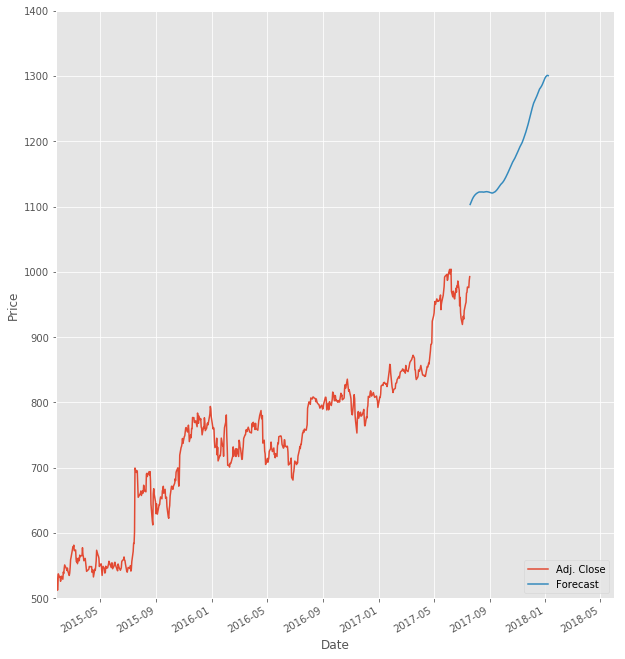

In [307]:
forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

fig, ax = plt.subplots(figsize=(10, 12))
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
ax.set_ylim([500, 1400])
ax.set_xlim([datetime.date(2015, 1, 26), datetime.date(2018, 6, 1)])
plt.show()

### This seems to resemble our data and the trend we actually observed during that time. We do not go into indepth analysis of the model here, but leave this as a good starting point. Some basic extensions to this model include: predicting not just values, but <i> confidence intervals </i> around the prediction (using various models for the noise). The next natural step would be to extend this to a more complicated model!